In [109]:
from importlib import reload
from copy import deepcopy
import os
from utils.data import MyData
from utils import utils
from torch.utils.data import DataLoader
import torch
import torchvision
from torchvision.transforms import ToTensor, RandomCrop, Compose
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import torchvision.transforms.functional as TF

if not os.path.isdir("./cache"): os.mkdir("cache")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')
print("Preparing data...")
mData = MyData()
print("Data is ready")

device: cuda
Preparing data...
Data is ready


## Net 12

In [456]:
Net12 = nn.Sequential(
    # 3 X 12 X 12
    nn.Conv2d(3, 16, kernel_size = 3, stride = 1),
    # 16 X 10 X 10
    utils.nn_Unsqueeze(1),
    # 1 X  16 X 10 X 10
    nn.MaxPool3d(kernel_size = [16, 3, 3], stride = 2),
    # 1 X 4 X 4
    nn.Flatten(),
    nn.Linear(4 * 4, 2)
)

Net12.to(device)
# train

model_path = "./cache/models.12Net.best_model"
if os.path.isfile(model_path):
    best_model = torch.load(model_path)

else:
    opt = optim.Adam(Net12.parameters(), lr=  1e-4)
    loss_fn = nn.CrossEntropyLoss()
    E = 10000
    l_loss, l_acc = {'train':[], 'test':[]}, {'train':[], 'test':[]}
    best_model, best_acc = None ,0
    for epoch in range(E):
        dl = mData.DataLoader(12, typ = 'train', batch_size = 256)
        dl_test = mData.DataLoader(12, typ = 'test', batch_size = 256)
        epoch_loss, epoch_acc = 0, 0
        # train epoch
        for x, y in dl:
            x, y = x.to(device), y.view(-1).type(torch.int64).to(device)
            y_pred = Net12(x)
            loss = loss_fn(y_pred, y)
            opt.zero_grad() ; loss.backward() ; opt.step()
            with torch.no_grad():
                epoch_acc += (y_pred.cpu().argmax(axis=1) == y.cpu()).type(torch.float32).mean()
            epoch_loss += loss 
        l_loss['train'].append(epoch_loss / len(dl))
        l_acc['train'].append(epoch_acc / len(dl))
        epoch_loss, epoch_acc = 0, 0
        # test
        for x,y in dl_test:
            x, y = x.to(device), y.view(-1).type(torch.int64).to(device)
            with torch.no_grad():
                y_pred = Net12(x)
                loss = loss_fn(y_pred, y)
                epoch_acc += (y_pred.cpu().argmax(axis=1) == y.cpu()).type(torch.float32).mean()
            epoch_loss += loss 
        # update best model
        l_loss['test'].append(epoch_loss / len(dl_test))
        l_acc['test'].append(epoch_acc / len(dl_test))
        if l_acc['test'][-1] > best_acc:
            best_acc = l_acc['test'][-1]
            best_model = deepcopy(Net12)
        if epoch % 100 == 0: 
            utils.print_during_train(epoch,l_loss, l_acc)
    torch.save(best_model.cpu(), model_path)

>>> Epoch 0, train: loss 0.7713 acc 0.4974, test: loss 0.7440 acc 0.5008, 
>>> Epoch 100, train: loss 0.4973 acc 0.7974, test: loss 0.4952 acc 0.8004, 
>>> Epoch 200, train: loss 0.3391 acc 0.8775, test: loss 0.3400 acc 0.8743, 
>>> Epoch 300, train: loss 0.2851 acc 0.8932, test: loss 0.2897 acc 0.8948, 
>>> Epoch 400, train: loss 0.2731 acc 0.8989, test: loss 0.2766 acc 0.8972, 
>>> Epoch 500, train: loss 0.2583 acc 0.9057, test: loss 0.2680 acc 0.9008, 
>>> Epoch 600, train: loss 0.2553 acc 0.9026, test: loss 0.2622 acc 0.9021, 
>>> Epoch 700, train: loss 0.2509 acc 0.9049, test: loss 0.2585 acc 0.9030, 
>>> Epoch 800, train: loss 0.2458 acc 0.9063, test: loss 0.2551 acc 0.9041, 
>>> Epoch 900, train: loss 0.2457 acc 0.9084, test: loss 0.2532 acc 0.9050, 


In [721]:
for x,y in dl_test:
    break
x = x[0]
y = y[0]
x.shape, y.shape

(torch.Size([3, 12, 12]), torch.Size([]))

(None, tensor(1))

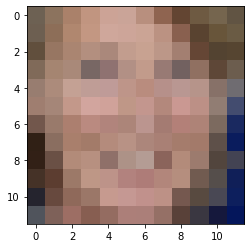

In [722]:
utils.plt_tensor(x), y

## Simple Detector

In [458]:
Net12 = torch.load("cache/models.12Net.best_model")
Net12_layers = list(Net12._modules.values())
conv_layer = nn.Conv2d(1, 2, kernel_size = 4, stride = 1)
conv_layer.weight.data = Net12_layers[-1].weight.data.view((2, 1, 4, 4)).detach().clone()
conv_layer.bias.data = Net12_layers[-1].bias.data.detach().clone()
Net12Detector_layers = [deepcopy(l) for l in Net12_layers[:-2]] + [utils.nn_Squeeze(1), conv_layer, nn.Softmax(dim = 1)]
Net12_FCN = nn.Sequential(*Net12Detector_layers)

In [735]:
def scale_fcn_boxes(x, scale, fcn_model, iou_threshold = 0.5):
    with torch.no_grad():
        x = x.unsqueeze(0)
        H, W = x.shape[-2:]
        xscaled = TF.resize(x, size = (int(scale * H), int(scale * W)))
        xout = fcn_model(xscaled)
        xnms, ls = utils.nms(xout, iou_threshold = iou_threshold, k =11, s = 2)
    return xnms[0, :ls[0], :]

In [764]:
reload(utils)
Net12_FCN = Net12_FCN.to(device)
def det_model(path):
    x = Image.open(path)
    x = TF.to_tensor(x).to(device)
    outs = []
    for scale in [0.05, 0.1, 0.3, 0.5, 0.7,1]:
        outs.append(scale_fcn_boxes(x, scale, Net12_FCN, iou_threshold = 0.5).cpu())
    return torch.cat(outs, 0)


In [765]:
utils.gen_fddb_out(det_model)

RuntimeError: dets must be a CUDA tensor

In [ ]:
reload(utils)
out = Net12_FCN(x)

In [755]:
a = torch.tensor([[1]])
b = torch.tensor([[2]])
torch.cat((a,b), 0)

tensor([[1],
        [2]])

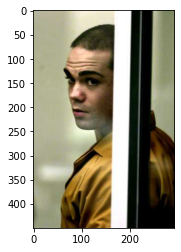

In [760]:
reload(utils)
x = Image.open("./data/EX2_data/fddb/images/2002/08/13/big/img_776.jpg")
plt.imshow(x)
x = TF.to_tensor(x)

In [745]:
scale = 0.1
r = scale_fcn_boxes(x, scale, Net12_FCN, 0.2)
r.shape

torch.Size([15, 5])

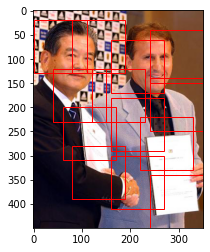

In [746]:
utils.plot_with_rec(x, r,scale =scale, limit = 0.9)

In [725]:
reload(utils)
x = torch.rand((2, 3,450, 377))
out = Net12_FCN(x)

In [256]:
out.shape

torch.Size([2, 2, 220, 184])

In [262]:
utils.nms(out, 0.4)[1, 1, :]

tensor([154.0000,   0.0000, 165.0000,  11.0000,   0.5950])

### FDDB

In [345]:
x._size

(275, 450)

In [346]:
x = TF.to_tensor(x)
x.shape
# x = TF.resize(x, size = (100, 100))

torch.Size([3, 450, 275])

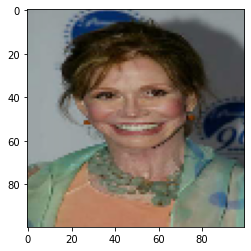

In [330]:
utils.plt_tensor(x)

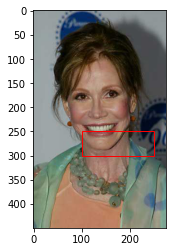

In [378]:

# Display the image
plt.imshow(x)
# Add the patch to the Axes
plt.gca().add_patch(Rectangle((100, 250),150, 50,linewidth=1,edgecolor='r',facecolor='none'))
